In [4]:
#from sSMC import MarginalDistr
import numpy as np
from numpy import dot

from scipy import linalg
from numpy import linalg as np_linalg
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import seaborn as sns


class MarginalDistr:

    def __init__(self, la1, la2, mu1, mu2):
        #mu1, mu2 - migration  rates
        #la1, la2 - coalescent rates
        #init_cond - vector of length 3
        self.la1 = la1
        self.la2 = la2
        
        self.mu1 = mu1
        self.mu2 = mu2

        #self.init_cond = np.array(init_cond)/sum(init_cond)

        self.SetMatrix(0.0)

    def m1(self, t):
        return self.mu1

    def m2(self, t):
        return self.mu2

    def l1(self, t):
        return self.la1

    def l2(self, t):
        return self.la2

    def SetMatrix(self, t):
        self.A = np.matrix( [[-2*self.m1(t)-self.l1(t), 0, self.m2(t)],
                             [0, -2*self.m2(t)-self.l2(t), self.m1(t)],
                             [2*self.m1(t), 2*self.m2(t), -self.m1(t) - self.m2(t)]] )

    def CalcProb(self, t, init_cond):
        MET = linalg.expm( dot(self.A, t) )
        return dot(MET, init_cond)

    def CalcDist(self, num_steps, step, init_cond):
        pr_dist = np.zeros(num_steps+1)
        MET = linalg.expm( dot(self.A, step) )
        for i in range(num_steps):
            pr_dist[i] = self.la1*init_cond[0]+self.la2*init_cond[1]
            init_cond = dot(MET, init_cond)
        pr_dist[num_steps] = self.la1*init_cond[0]+self.la2*init_cond[1]
        return pr_dist

In [2]:
class lineage:
    def __init__(self, a, b, p):
        #a and b indicates ancestral material (1) or non-ancestral (0)
        self.a = a
        self.b = b
        self.p = p#0 or 1 population

    def __str__(self):
        return str(self.a)+str(self.b)+str(self.p)

class state:
    def __init__(self, lng):
        self.lng = lng
        self.l = len(lng)
        self.name()
        self.stat()

    def name(self):
        lng_s = []
        for l in self.lng:
            lng_s.append( str(l.a) + str(l.b) + str(l.p) )
        lng_s.sort()
        self.n = ','.join(lng_s)
        
    def stat(self):
        self.num = {'a': 0, 'b': 0}
        self.index = {'a':[-1,-1],'b':[-1,-1]}
        ai, bi = 0, 0
        for i, l in enumerate(self.lng):
            if l.a == 1:
                self.num['a'] += 1
                self.index['a'][ai] = i
                ai += 1
            if l.b == 1:
                self.num['b'] += 1
                self.index['b'][bi] = i
                bi += 1
                
    def __str__(self):
        prstr = self.n + ": " + "num_a = " + str(self.num['a']) + ", " + "num_b = " + str(self.num['b']) + "\n    " + "index_a = " + str(self.index['a'][0:self.num['a']]) + "\n    " + "index_b = " + str(self.index['b'][0:self.num['b']])
        return(prstr)

numStates =[
#    [ [1,1,0] ],
#    [ [1,1,1] ],

    [ [1,1,0],[1,1,0] ],
    [ [1,1,0],[1,1,1] ],
    [ [1,1,1],[1,1,1] ],

    [ [1,0,0],[1,1,0] ],
    [ [1,0,0],[1,1,1] ],
    [ [1,0,1],[1,1,0] ],
    [ [1,0,1],[1,1,1] ],

    [ [0,1,0],[1,1,0] ],
    [ [0,1,0],[1,1,1] ],
    [ [0,1,1],[1,1,0] ],
    [ [0,1,1],[1,1,1] ],

    [ [0,1,0],[1,0,0] ],
    [ [0,1,0],[1,0,1] ],
    [ [0,1,1],[1,0,0] ],
    [ [0,1,1],[1,0,1] ],

    [ [1,0,0],[0,1,0],[1,1,0] ],
    [ [1,0,0],[0,1,0],[1,1,1] ],
    [ [1,0,0],[0,1,1],[1,1,0] ],
    [ [1,0,0],[0,1,1],[1,1,1] ],
    [ [1,0,1],[0,1,0],[1,1,0] ],
    [ [1,0,1],[0,1,0],[1,1,1] ],
    [ [1,0,1],[0,1,1],[1,1,0] ],
    [ [1,0,1],[0,1,1],[1,1,1] ],

    [ [1,0,0],[0,1,0],[0,1,0] ],
    [ [1,0,0],[0,1,0],[0,1,1] ],
    [ [1,0,0],[0,1,1],[0,1,1] ],
    [ [1,0,1],[0,1,0],[0,1,0] ],
    [ [1,0,1],[0,1,0],[0,1,1] ],
    [ [1,0,1],[0,1,1],[0,1,1] ],

    [ [1,0,0],[1,0,0],[0,1,0] ],
    [ [1,0,0],[1,0,0],[0,1,1] ],
    [ [1,0,0],[1,0,1],[0,1,0] ],
    [ [1,0,0],[1,0,1],[0,1,1] ],
    [ [1,0,1],[1,0,1],[0,1,0] ],
    [ [1,0,1],[1,0,1],[0,1,1] ],

    [ [1,0,0],[1,0,0],[0,1,0],[0,1,0] ],
    [ [1,0,0],[1,0,0],[0,1,0],[0,1,1] ],
    [ [1,0,0],[1,0,0],[0,1,1],[0,1,1] ],
    [ [1,0,0],[1,0,1],[0,1,0],[0,1,0] ],
    [ [1,0,0],[1,0,1],[0,1,0],[0,1,1] ],
    [ [1,0,0],[1,0,1],[0,1,1],[0,1,1] ],
    [ [1,0,1],[1,0,1],[0,1,0],[0,1,0] ],
    [ [1,0,1],[1,0,1],[0,1,0],[0,1,1] ],
    [ [1,0,1],[1,0,1],[0,1,1],[0,1,1] ]
]

Mdim = len(numStates)

states = []
stateToNum = {}
i = 0
for st in numStates:
    lng = []
    for l in st:
        lng.append( lineage(l[0], l[1], l[2]) )
    states.append( state(lng) )
    stateToNum[states[-1].n] = i
    i += 1

def Eq(P, t):
    return dot(dot(M,params(t)),P)

def Coal(st, i, k):
    if i > st.l or k > st.l:
        print("Wrong lineage index.")
    if st.lng[i].p != st.lng[k].p:
        print("Coalescence is impossible.")
    newState = [st.lng[j] for j in range(st.l) if i != j and k != j]
    newState.append(lineage(st.lng[i].a | st.lng[k].a, st.lng[i].b | st.lng[k].b, st.lng[i].p))
    newState = state(newState)
    if newState.l > 1:
        return stateToNum[newState.n]
    else:
        return -1

#Matrix entry [rho, l1, l2, m1, m2]

def Matrix():
    trRate = np.zeros( (Mdim, Mdim, 5), int )
    for s in range(Mdim):
        st = states[s]
        for i in range(st.l):
            #recombination
            if st.lng[i].a & st.lng[i].b:
                newState = [st.lng[j] for j in range(st.l) if i != j]
                newState.append(lineage(1,0,st.lng[i].p))
                newState.append(lineage(0,1,st.lng[i].p))
                newState = state(newState)
                trRate[s,stateToNum[newState.n],0] += 1
                trRate[s,s,0] -= 1
            #coalescence
            for k in range(i+1,st.l):
                if st.lng[i].p == st.lng[k].p:
                    newState_id = Coal(st, i, k)
                    if newState_id != -1:
                        trRate[s, newState_id, st.lng[i].p+1 ] += 1
                    trRate[s, s, st.lng[i].p+1 ] -= 1
            #migration
            newState = [st.lng[j] for j in range(st.l) if i != j]
            newState.append( lineage(st.lng[i].a,st.lng[i].b,(st.lng[i].p+1)%2) )
            newState = state(newState)
            trRate[s, stateToNum[newState.n], st.lng[i].p+3 ] += 1
            trRate[s, s, st.lng[i].p+3 ] -= 1
    return( np.transpose(trRate, (1,0,2)) )

def FirstCoal(locus, t, popID = -1):
    matr = np.zeros( (Mdim, Mdim) )
    for s, st in enumerate(states):
        if not (st.num['a'] == 2 and st.num['b'] == 2 and st.l > 2):
            continue
        lng_i0, lng_i1 = st.index[locus][0], st.index[locus][1]
        if not (popID == -1 and st.lng[lng_i0].p == st.lng[lng_i1].p) and not (popID != -1 and st.lng[lng_i0].p == popID and st.lng[lng_i1].p == popID):
            continue
        newState_id = Coal(st, lng_i0, lng_i1)
        matr[ newState_id, s ] += params(t)[ st.lng[lng_i0].p + 1 ]
    return matr

def SecondCoal(locus, t, popID = -1):
    matr = np.zeros( (Mdim, Mdim) )
    
    locus2 = 'b'
    if locus == 'b':
        locus2 = 'a'
        
    for s, st in enumerate(states):
        if not (st.num[locus] == 2 and st.num[locus2] == 1):
            continue
        lng_i0, lng_i1 = st.index[locus][0], st.index[locus][1]
        if not (popID == -1 and st.lng[lng_i0].p == st.lng[lng_i1].p) and not (popID != -1 and st.lng[lng_i0].p == popID and st.lng[lng_i1].p == popID):
            continue
        newState_id = Coal(st, lng_i0, lng_i1)
        #print(st.n, states[newState_id].n)
        matr[ newState_id, s ] += params(t)[ st.lng[lng_i0].p + 1 ]
    return matr

def DoubleCoal(t, popID = -1):
    matr = np.zeros( (Mdim, Mdim) )
    for s, st in enumerate(states):
        if not (st.num['a'] == 2 and st.num['b'] == 2 and st.l == 2):
            continue
        lng_i0, lng_i1 = st.index['a'][0], st.index['a'][1]
        if not (popID == -1 and st.lng[lng_i0].p == st.lng[lng_i1].p) and not (popID != -1 and st.lng[lng_i0].p == popID and st.lng[lng_i1].p == popID):
            continue
        newState_id = Coal(st, lng_i0, lng_i1)
        #print(st.n, states[newState_id].n)
        matr[ newState_id, s ] += params(t)[ st.lng[lng_i0].p + 1 ]
    return matr

def params(t):
    return np.array([0.0001, 1.0, 2.0, 0.1, 0.1])

M = Matrix()

Pinit = np.zeros(Mdim)
Pinit[0] = 1.0

T = 1.
S = 2.

def densityTaTb(Ta, Tb, pop_a = -1, pop_b = -1):
    if Ta < Tb:
        Mexp = linalg.expm( dot(M, params(0))*Ta )
        P = dot(Mexp, Pinit)
        #print(P)
        P = dot(FirstCoal('a', Ta, pop_a), P)
        #print(P)
        Mexp = linalg.expm( dot(M, params(0))*(Tb-Ta) )
        P = dot(Mexp, P)
        #print(P)
        P = dot(SecondCoal('b', Tb, pop_b), P)
        #print(P)
    elif Ta > Tb:
        Mexp = linalg.expm( dot(M, params(0))*Tb )
        P = dot(Mexp, Pinit)
        P = dot(FirstCoal('b', Tb, pop_b), P)
        Mexp = linalg.expm( dot(M, params(0))*(Ta-Tb) )
        P = dot(Mexp, P)
        P = dot(SecondCoal('a', Ta, pop_a), P)
    else:
        Mexp = linalg.expm( dot(M, params(0))*Ta )
        P = dot(Mexp, Pinit)
        P = dot(DoubleCoal(Ta, pop_a), P)
    return( sum(P) )

In [177]:
dim = 80
dt = 20

In [178]:
def params(t):
    return np.array([0.001, 1.0, 1.0, 0.1, 0.1])

data_dx = [[densityTaTb(i/dt, j/dt)/dt if i != j else densityTaTb(i/dt, j/dt) for j in range(dim)] for i in range(dim) ]
data_dx = np.array(data_dx)
row_sums = data_dx.sum(axis=1)
trans_matrix_smc = data_dx / row_sums[:, np.newaxis]

#margdist = md.CalcDist(dim, 1.0/dt, init_cond)
marg_diagonal = np.zeros( (dim, dim) )
for i in range(dim):
    marg_diagonal[i,i] = row_sums[i]# margdist[i]
    
#sum(trans_matrix_smc[0,:])

<AxesSubplot:>

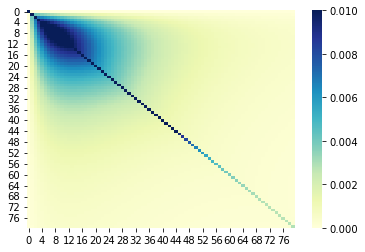

In [179]:
joint_smc = np_linalg.matrix_power(trans_matrix_smc, 1000)
joint_smc = np.matmul(marg_diagonal, joint_smc)

sns.heatmap(joint_smc, cmap="YlGnBu", vmax=0.01)

In [180]:
def params(t):
    return np.array([1.0, 1.0, 1.0, 0.1, 0.1])

data = [[densityTaTb(i/dt, j/dt)/dt if i != j else densityTaTb(i/dt, j/dt) for j in range(dim)] for i in range(dim) ]
data = np.array(data)

<AxesSubplot:>

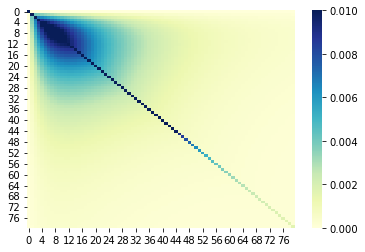

In [181]:
sns.heatmap(data, cmap="YlGnBu",vmax=0.01)

<AxesSubplot:>

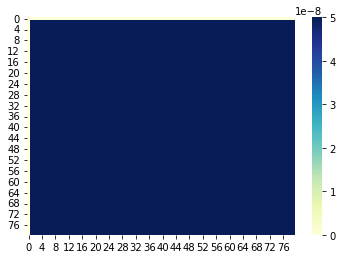

In [182]:
sns.heatmap(joint_smc-data, cmap="YlGnBu", vmax=0.00000005)

In [183]:
dif=joint_smc-data
np.sum(abs(dif))/dt/2
#0.054269666412373976

0.03948928654871754

In [131]:
import msprime
import math
demography = msprime.Demography()
demography.add_population(name="A", initial_size=1)
#demography.add_population(name="B", initial_size=2)
#demography.

counter = 0
emp_dist = np.zeros( (dim,dim) )
for _ in range(200000):
    ts = msprime.sim_ancestry(samples={"A": 2}, ploidy=1, demography=demography, recombination_rate=0.01, sequence_length=100)
    tree = ts.first()
    T = tree.time( tree.root )
    tree = ts.last()
    S = tree.time( tree.root )
    
    i = math.floor(T * dt)
    j = math.floor(S * dt)
    if i < dim and j < dim:
        emp_dist[i,j] += 1
emp_dist /= np.sum(emp_dist)

<AxesSubplot:>

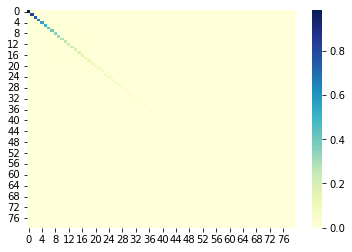

In [137]:
emp_dist_dt = emp_dist*dt

#for i in range(dim):
#    emp_dist[i,i] /= dt

sns.heatmap(emp_dist_dt, cmap="YlGnBu")

<AxesSubplot:>

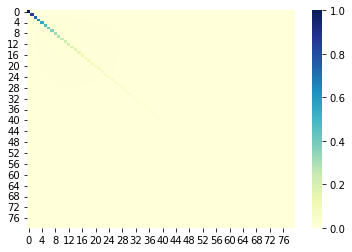

In [138]:
sns.heatmap(data, cmap="YlGnBu")

0.9697691641943803
3.31036586013115
0.10700337560813825


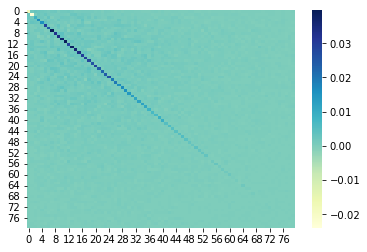

In [135]:
sns.heatmap(emp_dist_dt-data, cmap="YlGnBu")
dif=emp_dist_dt-data
TV_diag = 0.
for i in range(dim):
    TV_diag += abs(dif[i,i])
print(TV_diag)
TV = 0.
for i in range(dim):
    for j in range(dim):
        if i != j:
            TV += abs(dif[i,j])
print(TV)
TV = (TV_diag/dt + TV/dt)*0.5
print(TV)

#repl=100000
#9.424612746924156
#16.715550111722997
#0.09758923749158616

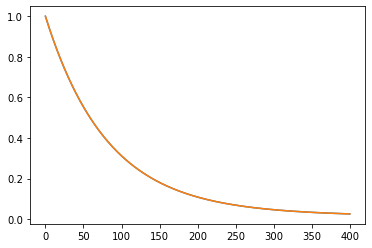

In [61]:
tau = 1.0/dt

Pinit = np.zeros(Mdim)
Pinit[0] = 1.0

Mexp = linalg.expm( dot(M, params(0))*tau )
margdist1 = []

#coal_vec = np.zeros(len(states))
coal_vec = []
for st in states:
    if st.num['a'] == 2:
        lng_i0, lng_i1 = st.index['a'][0], st.index['a'][1]
        if st.lng[lng_i0].p == st.lng[lng_i1].p:
            coal_vec.append( params(0)[st.lng[lng_i0].p + 1] )
        else:
            coal_vec.append( 0.0 )
    else:
        coal_vec.append( 0.0 )
coal_vec = np.array(coal_vec)

for i in range(dim+1):
    margdist1.append( dot(Pinit, coal_vec) )
    Pinit = dot(Mexp, Pinit)
    
plt.plot(margdist1)
plt.plot(margdist)

0.3120980077710087
[0.31562153 0.31210164 0.30862432]


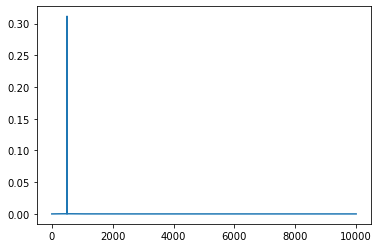

In [88]:
dens = [densityTaTb(1., j/500) for j in range(10000)]
print( dens[500]+sum(dens[:500])/500+sum(dens[501:])/500 )
print(margdist[99:102])
plt.plot(dens)

if False:
    Mfc = FirstCoal('a',1)
    for i in range(len(states)):
        for j in range(len(states)):
            if Mfc[i,j] != 0:
                print(states[i].n + ' ' + states[j].n + ' ' + str(Mfc[i,j]) )

    print("---------")

    Msc = SecondCoal('b',1)
    for i in range(len(states)):
        for j in range(len(states)):
            if Msc[i,j] != 0:
                print(states[i].n + ' ' + states[j].n + ' ' + str(Msc[i,j]) )

In [39]:
class test_c:
    def __init__(self, method):
        self.method = method
        
    def call(self, t):
        self.method(t)
        
def test_f1(t):
    print("1: ", t)
    
def test_f2(t):
    print("2: ", t)
    
tc1 = test_c(test_f1)
tc1.call("hi")

tc2 = test_c(test_f2)
tc2.call("hi")

1:  hi
2:  hi
